# My Own Decision Tree Classifier

In [538]:
# import data
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target
y[y==1]=0
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

In [539]:
import numpy as np
def label_it(D):
  """ return the most likely class """
  X,y = D
  v,c = np.unique(y,return_counts=True)
  ind = np.argmax(c)
  return v[ind]

def to_freq(y,w,debug=False):
  """convert to frequencies for each class"""
  p =np.array([len(y[y==cl])/len(y) for cl in np.unique(y)])
  weight = np.array([sum(w[y==cl]) for cl in np.unique(y)])
  if debug:
    print('from function to_freq',p)
  return p,weight

def split_data(D,split):
  """split the data set"""
  X,y = D
  idx, threshold = split
  idx=int(idx)
    
  idx_l = X[:,idx] <= threshold;
  idx_r = X[:,idx] > threshold;
    
  Xl=X[X[:,idx] <= threshold,:]
  yl=y[X[:,idx] <= threshold]
  Xr=X[X[:,idx] > threshold,:]
  yr=y[X[:,idx] > threshold]

  Dl = (Xl,yl)
  Dr = (Xr,yr)
  return (Dl,Dr,idx_l,idx_r)


def get_thresholds_from_vec(x):
  """ thresholds are the middle points of consecutive unique points """
  return 0.5*np.diff(np.unique(x)) + np.unique(x)[:-1]

def get_threshold_from_mat(X):
  """ call get_thresholds from vec, and zip all the results """
  ns,nf = X.shape
  tmp=[get_thresholds_from_vec(X[:,i]) for i in range(nf)]
  ids = np.concatenate([(i*np.ones(len(item))) for i, item in zip(np.arange(nf),tmp)])
  return [(idx,t) for idx, t in zip(ids,np.concatenate(tmp))]

def get_imp(p,w,metric='entropy'):
  """ Calculate the impurity index
  p: is the probability vector, the sum of which equal to 1 """
  return {
       'entropy': (-p*np.log2(p)).dot(w),
       'error' : (1-np.max(p))*w[np.argmax(p)],
       'gini': (p*(1-p)).dot(w)
      }.get(metric)

def info_gain(D,split,w,metric='entropy'):
  """ the information gain of a given split
  split: (idx_feature, threshold) is a tuple """
  Dl,Dr,idx_l,idx_r = split_data(D,split)
  Nl = sum(w[idx_l])#len(Dl[1])
  Nr = sum(w[idx_r])#len(Dr[1])
  Np = sum(w)#len(D[1])
  #print(Dl[1])
  #print(w[idx_l]) 
  pl,weight_l =  to_freq(Dl[1],w[idx_l])
  pr,weight_r = to_freq(Dr[1],w[idx_r])
  p,weight = to_freq(D[1],w)
  Il = get_imp(pl,weight_l,metric=metric)
  Ir = get_imp(pr,weight_r,metric=metric)
  Ip = get_imp(p,weight,metric=metric)
  return Np*(Ip - Nl/Np * Il - Nr/Np*Ir)


###################################################
# class definition 
class BT_node(object):
  """ a simple binary tree node base class"""
  def __init__(self,Data=None,weight=None,parent=None,metric='entropy',max_depth=1):
    self.Data = Data
    self.w=weight
    self.parent = parent
    self.metric = metric
    self.max_depth=max_depth

  def update(self):
    self.level = self.parent.level+1 if self.parent is not None  else 0
    self.label = label_it(self.Data)
    X,y = self.Data
    sps = get_threshold_from_mat(X)
    # number of samples are 1 or zero || uniform class || max level reached || some features are identical, but labels are different
    if len(y) <= 1 or self.level>=self.max_depth or len(sps)==0:
        self.lchild = None
        self.rchild = None
        self.split = None
    else:
        #print(self.Data[0])
        split,Dl,Dr,wl,wr = self.get_child(sps)
        #print(split)
        self.lchild = BT_node(Data=Dl,weight=wl,parent=self,max_depth=self.max_depth)
        self.lchild.update()
        self.rchild = BT_node(Data=Dr,weight=wr,parent=self,max_depth=self.max_depth)
        self.rchild.update()
        self.split = split
        self.updated = True
        return self
    
  def get_child(self,sps):
    """ train the decision tree """
    X,y = self.Data
    IGs = np.array([info_gain((X,y),sp,self.w,self.metric) for sp in sps])
    # return the first maximum information gain
    cond = IGs==np.max(IGs)
    self.IG_max = IGs[cond]
    tmp = np.array(sps)[cond]
    split = (int(tmp[0,0]),tmp[0,1])
    # calculate the class label 
    Dl,Dr,idx_l,idx_r = split_data((X,y),split)
    return (split,Dl,Dr,self.w[idx_l],self.w[idx_r])


  def info(self):
    """ print out informations """
    print('split is: ',self.split)
    print('childrens are: ',self.lchild,self.rchild)
    print('node depth is: ',self.level)
    print('parent is: ',self.parent)



class Decision_Tree(object):
  """ Decision Tree, by Wensheng Sun"""
  def __init__(self,max_depth=3,random_state=1,impurity_fun='entropy',debug=False):
    self.random_state=random_state
    self.impurity_fun = impurity_fun
    self.max_depth = max_depth
    self.debug = debug

  def fit(self,X,y,w):
    """ growing the Binary Tree """
    self.root = BT_node((X,y),w,metric=self.impurity_fun,max_depth=self.max_depth)
    self.root.update()
    self.root.info()
    
  def find_leaf(self,x):
    node = self.root
    while True:
        if node.split is None:
            break
        else:
            if x[node.split[0]] <= node.split[1]:
            # print('the %d feature is less than threshold %.2f' %node.split)
                node = node.lchild
            else:
                node = node.rchild
    return node.label
    
  def predict(self,X):
    """ predict the results"""
    if len(X.shape)==1:
        X = [X]
    return np.array([self.find_leaf(x) for x in X])



In [588]:
  # instantiate the Decision Tree classifier
  dc = Decision_Tree(impurity_fun='error',max_depth=3)
  w = np.ones(y_train.shape)/len(y_train)
  #rgen =np.random.RandomState(5)
  w = rgen.normal(loc=1,scale=0.1,size=y_train.shape)
  #w[[88, 90,100]] = 1
  w = w/sum(w)
  #print(w)
  dc.fit(X_train,y_train,w)


split is:  (0, 4.75)
childrens are:  <__main__.BT_node object at 0x7f86eb180fd0> <__main__.BT_node object at 0x7f86eb4c7b00>
node depth is:  0
parent is:  None


In [589]:
sum(dc.predict(X_test)!=y_test)

3

In [590]:
y_test

array([0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2,
       0])

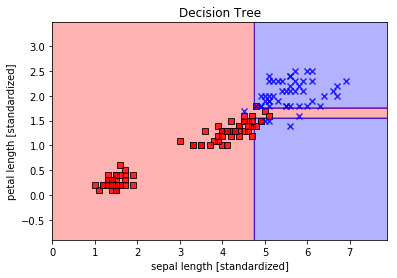

In [591]:
  import pandas as pd
  import matplotlib.pyplot as plt
  import numpy as np
  from Perceptron import plot_decision_regions

  #plt.figure()
  plot_decision_regions(X,y,classifier=dc)
  plt.title('Decision Tree')
  plt.xlabel('sepal length [standardized]')
  plt.ylabel('petal length [standardized]')
  plt.show()


In [544]:
dc.root.rchild.lchild.info()

split is:  (0, 5.05)
childrens are:  <__main__.BT_node object at 0x7f86eb33e320> <__main__.BT_node object at 0x7f86eb33e400>
node depth is:  2
parent is:  <__main__.BT_node object at 0x7f86eb33e470>


In [545]:
0.5*np.diff(np.unique(X_train[:,0])) + np.unique(X_train[:,0])[:-1]

array([1.25, 1.35, 1.45, 1.55, 1.65, 1.8 , 2.45, 3.15, 3.4 , 3.6 , 3.75,
       3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85,
       4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65, 5.75, 5.85, 5.95,
       6.05, 6.25, 6.5 , 6.65, 6.8 ])

In [546]:
np.unique(X_train[:,0])

array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.9, 3. , 3.3, 3.5, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.4, 6.6, 6.7, 6.9])

In [547]:
a=get_threshold_from_mat(X_train[[X_train[:,0]==4.8]])
len(a)

0

In [548]:
np.unique(X_train)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6,
       1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 3. , 3.3, 3.5, 3.7,
       3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ,
       5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.4, 6.6,
       6.7, 6.9])

In [549]:
[] is None

False

In [550]:
dc.predict(X_test[0,:])

array([0])

In [551]:
X_test[0,:]

array([4.2, 1.5])